In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *
import spatial
from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [92]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2
defaultclock.dt = 1*ms

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 10,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 10,
    'sequence_count': 10,
    'ISI': 500*ms,
}

In [4]:
def create_weights(params, rng):
    X, Y = spatial.generate_circle_locations(params['N'], params['r_dish'], rng)
    iPre_exc, iPost_exc, distance_exc = spatial.get_boxcar_connections(
        X[:params['N_exc']], Y[:params['N_exc']],
        X, Y,
        radius=params['r_exc'], outdegree=params['outdeg_exc'], rng=rng
    )
    iPre_inh, iPost_inh, distance_inh = spatial.get_boxcar_connections(
        X[params['N_exc']:], Y[params['N_exc']:],
        X, Y,
        radius=params['r_inh'], outdegree=params['outdeg_inh'], rng=rng
    )
    
    W_exc = rng.lognormal(params['w_exc_mean'], params['w_exc_sigma'], iPre_exc.shape)
    W_inh = rng.lognormal(params['w_inh_mean'], params['w_inh_sigma'], iPre_inh.shape)
    W = np.full((params['N'], params['N']), np.nan)
    W[iPre_exc, iPost_exc] = W_exc
    W[iPre_inh + params['N_exc'], iPost_inh] = W_inh

    D = np.full_like(W, np.nan)
    D[iPre_exc, iPost_exc] = distance_exc
    D[iPre_inh, iPost_inh] = distance_inh

    return X, Y, W, D

In [60]:
def create_excitatory(Net, X, Y, params, rng : np.random.Generator):
    # Noisy dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem + vnoise_std*sqrt(2/tau_noise)*xi : volt (unless refractory)
    excitatory_eqn = '''
        dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem : volt (unless refractory)
        dg_exc/dt = -g_exc/tau_ampa : 1
        dg_inh/dt = -g_inh/tau_gaba : 1
        dth_adapt/dt = -th_adapt/th_tau : volt
        x : meter
        y : meter
    '''
    excitatory_threshold = 'v > v_threshold + th_adapt'
    excitatory_reset = '''
        v = v_reset
        th_adapt += th_ampl
    '''

    Exc = NeuronGroup(params['N_exc'], excitatory_eqn, threshold=excitatory_threshold, reset=excitatory_reset, refractory=params['refractory_exc'],
                    method='euler', namespace=params, name='Exc')
    Exc.x, Exc.y = X[:params['N_exc']], Y[:params['N_exc']]
    voltage_init = 'rand() * (v_threshold - v_reset) + v_reset'
    Exc.v = voltage_init
    Exc.th_adapt = 0
    Exc.g_exc, Exc.g_inh = 0, 0
    Exc.add_attribute('dynamic_variables')
    Exc.add_attribute('dynamic_variable_initial')
    Exc.dynamic_variables = ['v', 'th_adapt', 'g_exc', 'g_inh']
    Exc.dynamic_variable_initial = [voltage_init, 0, 0, 0]

    Net.add(Exc)
    return Exc

In [61]:
def create_inhibitory(Net, X, Y, params, rng : np.random.Generator):
    # Noisy dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem + vnoise_std*sqrt(2/tau_noise)*xi : volt (unless refractory)
    inhibitory_eqn = '''
        dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem : volt (unless refractory)
        dg_exc/dt = -g_exc/tau_ampa : 1
        dg_inh/dt = -g_inh/tau_gaba : 1
        x : meter
        y : meter
    '''
    inhibitory_threshold = 'v > v_threshold'
    inhibitory_reset = 'v = v_reset'

    Inh = NeuronGroup(params['N_inh'], inhibitory_eqn, threshold=inhibitory_threshold, reset=inhibitory_reset, refractory=params['refractory_inh'],
                    method='euler', namespace=params, name='Inh')
    Inh.x, Inh.y = X[params['N_exc']:], Y[params['N_exc']:]
    voltage_init = 'rand() * (v_threshold - v_reset) + v_reset'
    Inh.v = voltage_init
    Inh.g_exc, Inh.g_inh = 0, 0
    Inh.add_attribute('dynamic_variables')
    Inh.add_attribute('dynamic_variable_initial')
    Inh.dynamic_variables = ['v', 'g_exc', 'g_inh']
    Inh.dynamic_variable_initial = [voltage_init, 0, 0]

    Net.add(Inh)
    return Inh

In [160]:
def create_excitatory_synapses(Net, params, Exc, Inh, W, D):
    excitatory_synapse = '''
        dxr/dt = (1-xr)/tau_rec : 1 (event-driven)
        w : 1
    '''
    excitatory_on_pre = '''
        g_exc_post += U*xr*w
        xr -= U*xr
    '''
    iPre_ee, iPost_ee = np.nonzero(~np.isnan(W[:params['N_exc'], :params['N_exc']]))
    iPre_ei, iPost_ei = np.nonzero(~np.isnan(W[:params['N_exc'], params['N_exc']:]))

    Syn_EE = Synapses(Exc, Exc, excitatory_synapse, on_pre=excitatory_on_pre, method='exact', namespace=params, name='EE')
    Syn_EE.connect(i=iPre_ee, j=iPost_ee)
    Syn_EE.w = W[iPre_ee, iPost_ee].ravel()
    Syn_EE.xr = 1
    Syn_EE.add_attribute('dynamic_variables')
    Syn_EE.add_attribute('dynamic_variable_initial')
    Syn_EE.dynamic_variables = ['xr']
    Syn_EE.dynamic_variable_initial = [1]
    Syn_EE.add_attribute('num_synapses')
    Syn_EE.num_synapses = len(iPre_ee)

    Syn_EI = Synapses(Exc, Inh, excitatory_synapse, on_pre=excitatory_on_pre, method='exact', namespace=params, name='EI')
    Syn_EI.connect(i=iPre_ei, j=iPost_ei)
    Syn_EI.w = W[iPre_ei, iPost_ei + params['N_exc']].ravel()
    Syn_EI.xr = 1
    Syn_EI.add_attribute('dynamic_variables')
    Syn_EI.add_attribute('dynamic_variable_initial')
    Syn_EI.dynamic_variables = ['xr']
    Syn_EI.dynamic_variable_initial = [1]
    Syn_EI.add_attribute('num_synapses')
    Syn_EI.num_synapses = len(iPre_ei)

    Net.add(Syn_EE, Syn_EI)
    return Syn_EE, Syn_EI

In [63]:
def create_inhibitory_synapses(Net, params, Exc, Inh, W, D):
    inhibitory_synapse = 'w : 1'
    inhibitory_on_pre = '''
        g_inh_post += w
    '''
    iPre_ie, iPost_ie = np.nonzero(~np.isnan(W[params['N_exc']:, :params['N_exc']]))
    iPre_ii, iPost_ii = np.nonzero(~np.isnan(W[params['N_exc']:, params['N_exc']:]))

    Syn_IE = Synapses(Inh, Exc, inhibitory_synapse, on_pre=inhibitory_on_pre, method='exact', name='IE')
    Syn_IE.connect(i=iPre_ie, j=iPost_ie)
    Syn_IE.w = W[iPre_ie + params['N_exc'], iPost_ie].ravel()

    Syn_II = Synapses(Inh, Inh, inhibitory_synapse, on_pre=inhibitory_on_pre, method='exact', name='II')
    Syn_II.connect(i=iPre_ii, j=iPost_ii)
    Syn_II.w = W[iPre_ii + params['N_exc'], iPost_ii + params['N_exc']].ravel()

    Net.add(Syn_IE, Syn_II)
    return Syn_IE, Syn_II

In [64]:
def create_stimulus_locations(params):
    polar2z = lambda r, θ: r * np.exp(1j * θ)
    theta = np.arange(params['N_stimuli']) / params['N_stimuli'] * 2*np.pi
    r = params['stim_distribution_radius']
    return r*np.cos(theta), r*np.sin(theta)

In [65]:
def get_stimulated(X, Y, Xstim, Ystim, params):
    idx = np.empty((params['N_stimuli'], params['neurons_per_stim']), dtype=int)
    for i in range(params['N_stimuli']):
        dist = spatial.get_distance(X, Y, Xstim[i], Ystim[i])
        sorted = np.argsort(dist)
        idx[i] = sorted[:params['neurons_per_stim']]
    return idx

In [66]:
def create_input(Net, X, Y, Xstim, Ystim, params, Exc, Inh):
    Input = SpikeGeneratorGroup(params['N_stimuli'], [], []*ms, name='Input')
    idx = get_stimulated(X, Y, Xstim, Ystim, params)
    
    Input_Exc = Synapses(Input, Exc, name='Input_Exc', method='exact',
                         on_pre=f'g_exc_post += {params["input_strength"]}')
    e = np.nonzero(idx < params['N_exc'])
    Input_Exc.connect(i=e[0], j=idx[e])
    
    Input_Inh = Synapses(Input, Inh, name='Input_Inh', method='exact',
                         on_pre=f'g_exc_post += {params["input_strength"]}')
    i = np.nonzero(idx >= params['N_exc'])
    Input_Inh.connect(i=i[0], j=idx[i] - params['N_exc'])

    Net.add(Input, Input_Exc, Input_Inh)
    return Input, Input_Exc, Input_Inh

In [168]:
def create_spikemonitors(Net, Exc, Inh):
    SpikeMon_Exc = SpikeMonitor(Exc, name='SpikeMon_Exc')
    SpikeMon_Inh = SpikeMonitor(Inh, name='SpikeMon_Inh')
    Net.add(SpikeMon_Exc, SpikeMon_Inh)
    return SpikeMon_Exc, SpikeMon_Inh

In [169]:
def create_statemonitors(Net):
    monitors = []
    for obj in Net:
        if hasattr(obj, 'dynamic_variables'):
            monitor = StateMonitor(
                obj, obj.dynamic_variables, name=f'StateMon_{obj.name}',
                record=range(obj.num_synapses) if hasattr(obj, 'num_synapses') else True)
            monitors.append(monitor)
    Net.add(*monitors)
    return monitors

In [171]:
def create_network_reset(Net, dt):
    resets = []
    for obj in Net:
        if hasattr(obj, 'dynamic_variables') and hasattr(obj, 'dynamic_variable_initial'):
            reset = '\n'.join([f'{var} = {init}'
                              for var, init in zip(obj.dynamic_variables, obj.dynamic_variable_init)
                              if init is not None])
            if len(reset):
                reg = obj.run_regularly(reset, dt=dt)
                resets.append(reg)
    Net.add(*reg)
    return resets

In [172]:
def create_network(X, Y, Xstim, Ystim, W, D, params, rng, reset_dt = None):
    Net = Network()
    Exc = create_excitatory(Net, X, Y, params, rng)
    Inh = create_inhibitory(Net, X, Y, params, rng)
    Syn_EE, Syn_EI = create_excitatory_synapses(Net, params, Exc, Inh, W, D)
    Syn_IE, Syn_II = create_inhibitory_synapses(Net, params, Exc, Inh, W, D)
    Input, Input_Exc, Input_Inh = create_input(Net, X, Y, Xstim, Ystim, params, Exc, Inh)
    SpikeMon_Exc, SpikeMon_Inh = create_spikemonitors(Net, Exc, Inh)
    state_monitors = create_statemonitors(Net)
    if reset_dt is not None:
        resets = create_network_reset(Net, reset_dt)
    return Net

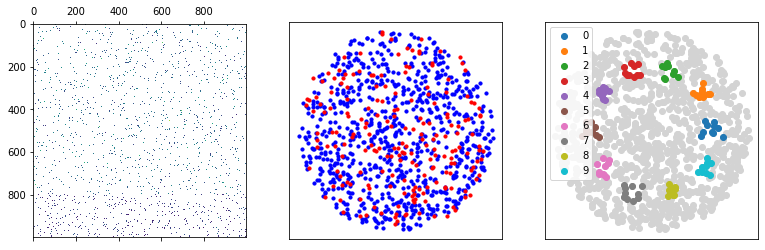

In [15]:
X, Y, W, D = create_weights(params, rng)
Xstim, Ystim = create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [16]:
# Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
# Net.run(30*second)

In [173]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SpikeMon_{k}'].t/second, net[f'SpikeMon_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SpikeMon_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

In [18]:
# raster(Net);

In [19]:
def set_input_sequence(Net, sequence, params):
    t = np.arange(len(sequence)) * params['ISI'] + params['settling_period']
    Net['Input'].set_spikes(sequence, t)
    return len(sequence) * params['ISI'] + params['settling_period']

In [20]:
def create_oddball(Net, params, A, B):
    sequence = np.tile([A] * (params['sequence_length']-1) + [B], params['sequence_count'])
    return sequence, set_input_sequence(Net, sequence, params)

In [21]:
def create_MSC(Net, params, rng : np.random.Generator):
    base_sequence = np.arange(params['N_stimuli'])
    rng.shuffle(base_sequence)
    sequence = np.tile(base_sequence, params['sequence_count'])
    return sequence, set_input_sequence(Net, sequence, params)

In [174]:
def get_episode_spikes(Net, params, episode=0, sorted=True):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t > t0) & (t < t0 + episode_duration)
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    return I, T

In [23]:
def get_neuron_spike_counts(N, pulsed_i, sequence, target_item):
    numspikes = np.zeros(N, dtype=int)
    for pulse_idx, pulse_item in enumerate(sequence):
        if pulse_item == target_item:
            np.add.at(numspikes, pulsed_i[pulse_idx], 1)
    return numspikes

In [24]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [25]:
def get_pulse_spike_counts(Net, params):
    I, T = get_episode_spikes(Net, params)
    return get_pulse_spike_counts_TMP(T, params['ISI'])

In [26]:
def populate_spike_results(Net, params, results):
    results['nspikes'] = get_pulse_spike_counts(Net, params)
    results['spike_i'], results['spike_t'] = get_episode_spikes(Net, params)
    results['pulsed_i'], results['pulsed_t'] = zip(*list(iterspikes(
        results['spike_i'], results['spike_t'],
        params['sequence_length']*params['sequence_count'], params['ISI'])))

In [53]:
def plot_sequence_spikecounts(results, A, B, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(np.arange(len(results['nspikes']))[results['Seq']==A], results['nspikes'][results['Seq']==A], c='r')
    ax.scatter(np.arange(len(results['nspikes']))[results['Seq']==B], results['nspikes'][results['Seq']==B], c='b')
    ax.set_ylim(bottom=0)
    ax.set_ylabel('# spikes')
    ax.set_xlabel('Stimulus index')

In [28]:
def draw_active_neurons(Net, X, Y, ax, results, target_items, colors, labels=None, overlaps={'_all': '*'}):
    ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.3)
    if labels is None:
        labels = [None]*len(target_items)
    num_spikes = []
    for target_item in target_items:
        n = get_neuron_spike_counts(
            len(X), results['pulsed_i'], results['Seq'], target_item)
        num_spikes.append(n)
    if '_all' in overlaps:
        overlaps_all = np.prod(num_spikes, axis=0) > 0
    for n, target_item, color, label in zip(num_spikes, target_items, colors, labels):
        mask = n > 0
        if mask.sum():
            ax.scatter(X[mask], Y[mask], color=color, alpha=n[mask] / n.max(), label=label)
            ax.scatter(X[mask], Y[mask], edgecolors=color, facecolor='none', alpha=.5)

        for key, marker in overlaps.items():
            if key == '_all':
                omask = mask & overlaps_all
            elif key == target_item:
                other_activity = np.zeros_like(mask)
                for n_, i_ in zip(num_spikes, target_items):
                    if n_ is not n:
                        other_activity |= n_ > 0
                omask = mask & other_activity
            else:
                continue
            if omask.sum():
                ax.scatter(X[omask], Y[omask], edgecolors=color, facecolor='none', marker=marker, s=200)

In [ ]:
# def draw_active_synapses(Net, X, Y, ax, results, target_items, colors, labels=None):
#     ax.scatter(X, Y, edgecolor='lightgrey', facecolor='none', alpha=.3)
#     if labels is None:
#         labels = [None]*len(target_items)
    

In [115]:
device.reinit()
device.activate()

In [116]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
A, B = 0, 5
Astd = {}
Astd['Seq'], T = create_oddball(Net, params, A, B)
Net.run(T)
populate_spike_results(Net, params, Astd)

Exc 148.84803922 mHz
Inh 251.37254902 mHz
Exc 148.84803922 mHz
Inh 251.37254902 mHz


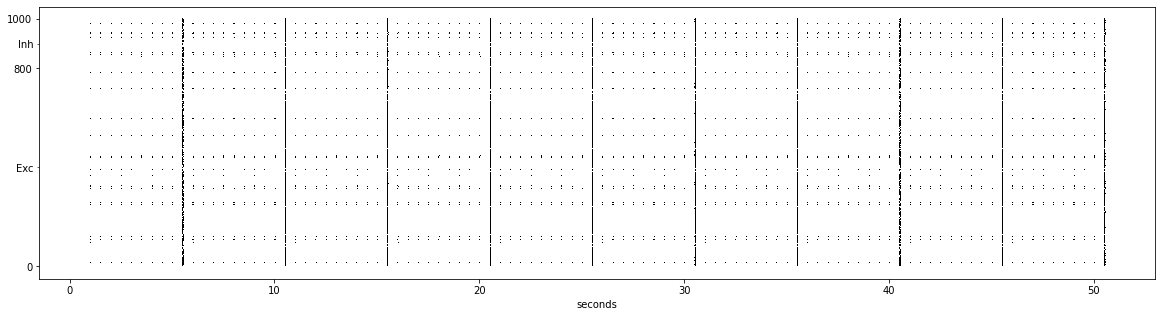

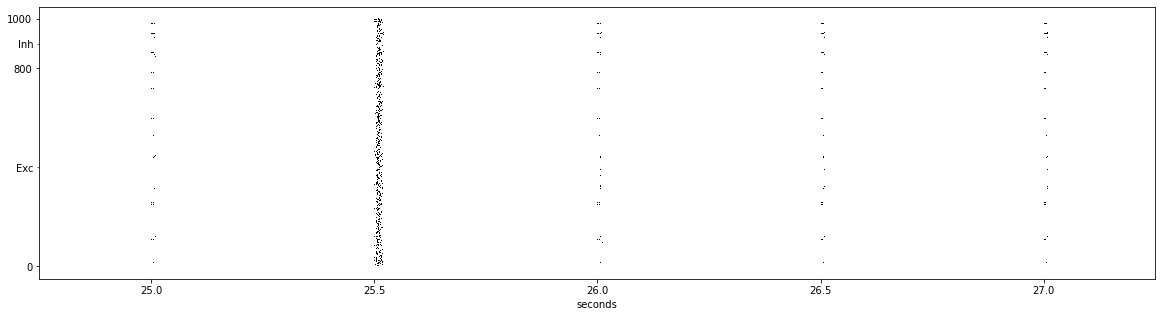

In [117]:
raster(Net)
raster(Net).set_xlim(47.5*params['ISI'] + params['settling_period'], 52.5*params['ISI'] + params['settling_period']);

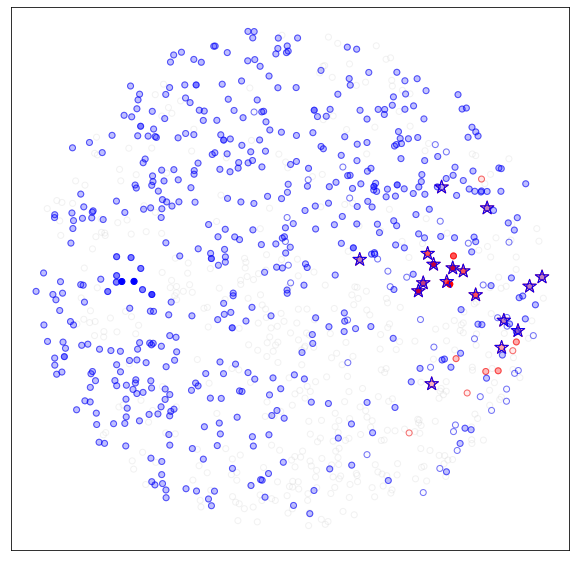

In [118]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, Astd, (A,B), ('r', 'b'))

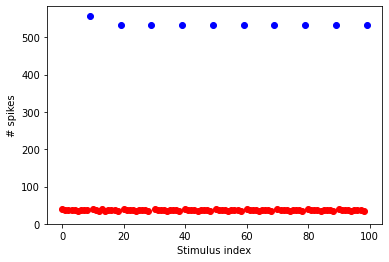

In [119]:
plot_sequence_spikecounts(Astd, A, B)

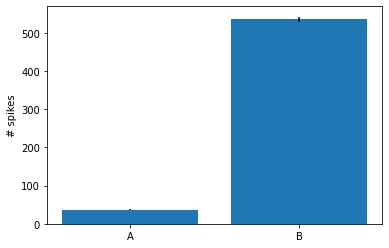

In [120]:
Astd['mean_A'], Astd['std_A'] = np.mean(Astd['nspikes'][Astd['Seq']==A]), np.std(Astd['nspikes'][Astd['Seq']==A])
Astd['mean_B'], Astd['std_B'] = np.mean(Astd['nspikes'][Astd['Seq']==B]), np.std(Astd['nspikes'][Astd['Seq']==B])
plt.bar(['A', 'B'], [Astd['mean_A'], Astd['mean_B']], yerr=[Astd['std_A'], Astd['std_B']])
plt.ylabel('# spikes');

In [121]:
device.reinit()
device.activate()

In [122]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
Bstd = {}
Bstd['Seq'], T = create_oddball(Net, params, B, A)
Net.run(T)
populate_spike_results(Net, params, Bstd)

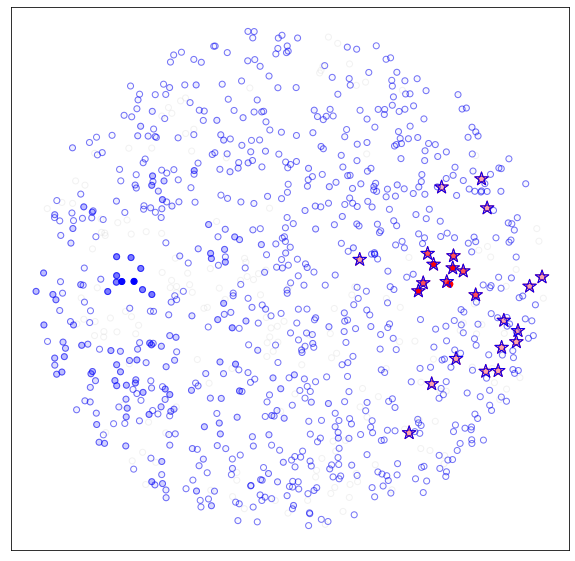

In [123]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, Bstd, (A,B), ('r', 'b'))

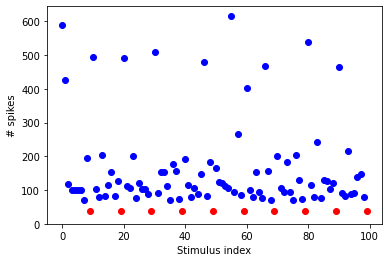

In [124]:
plot_sequence_spikecounts(Bstd, A, B)

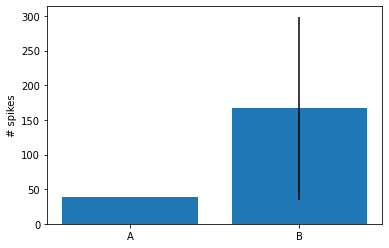

In [125]:
Bstd['mean_A'], Bstd['std_A'] = np.mean(Bstd['nspikes'][Bstd['Seq']==A]), np.std(Bstd['nspikes'][Bstd['Seq']==A])
Bstd['mean_B'], Bstd['std_B'] = np.mean(Bstd['nspikes'][Bstd['Seq']==B]), np.std(Bstd['nspikes'][Bstd['Seq']==B])
plt.bar(['A', 'B'], [Bstd['mean_A'], Bstd['mean_B']], yerr=[Bstd['std_A'], Bstd['std_B']])
plt.ylabel('# spikes');

In [137]:
device.reinit()
device.activate()

In [138]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
MSC = {}
MSC['Seq'], T = create_MSC(Net, params, rng)
Net.run(T)
populate_spike_results(Net, params, MSC)

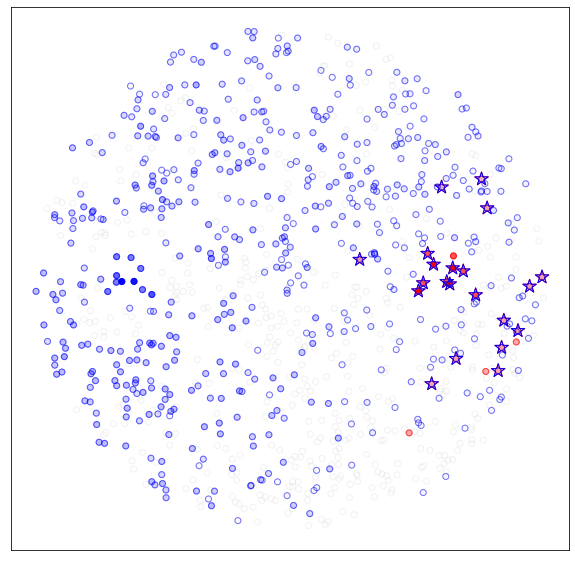

In [139]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(Net, X, Y, ax, MSC, (A,B), ('r', 'b'))

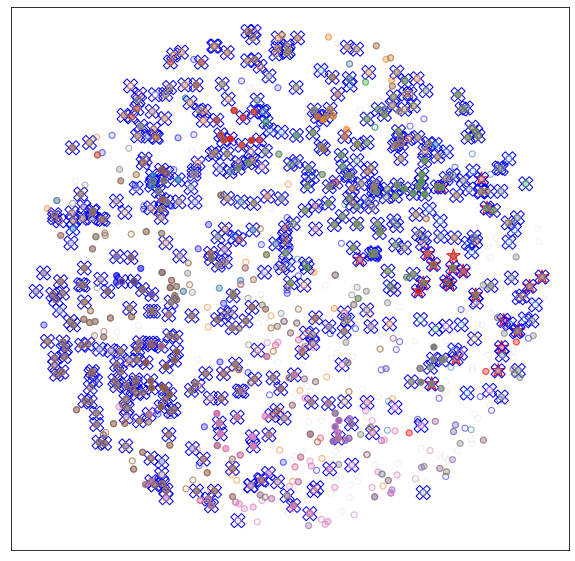

In [140]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
draw_active_neurons(
    Net, X, Y, ax, MSC,
    (A, B, *[x for x in MSC['Seq'][:10] if x not in (A,B)]),
    ('r', 'b', *[f'C{i}' for i in range(10)]),
    overlaps={A: '*', B: 'X'})

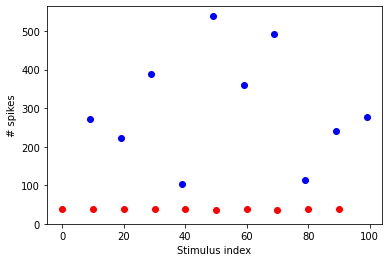

In [141]:
plot_sequence_spikecounts(MSC, A, B)

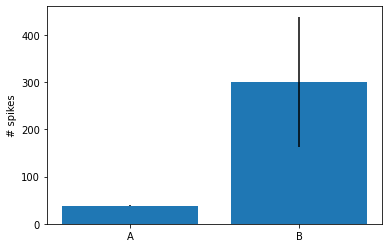

In [142]:
MSC['mean_A'], MSC['std_A'] = np.mean(MSC['nspikes'][MSC['Seq']==A]), np.std(MSC['nspikes'][MSC['Seq']==A])
MSC['mean_B'], MSC['std_B'] = np.mean(MSC['nspikes'][MSC['Seq']==B]), np.std(MSC['nspikes'][MSC['Seq']==B])
plt.bar(['A', 'B'], [MSC['mean_A'], MSC['mean_B']], yerr=[MSC['std_A'], MSC['std_B']])
plt.ylabel('# spikes');

In [143]:
nspikes_std = np.concatenate([Astd['nspikes'][Astd['Seq']==A], Bstd['nspikes'][Bstd['Seq']==B]])
nspikes_dev = np.concatenate([Astd['nspikes'][Astd['Seq']==B], Bstd['nspikes'][Bstd['Seq']==A]])
nspikes_msc = np.concatenate([MSC['nspikes'][MSC['Seq']==A], MSC['nspikes'][MSC['Seq']==B]])
mean_std, stddev_std = nspikes_std.mean(), nspikes_std.std()
mean_dev, stddev_dev = nspikes_dev.mean(), nspikes_dev.std()
mean_msc, stddev_msc = nspikes_msc.mean(), nspikes_msc.std()
contrast_dev_std = (mean_dev - mean_std) / (mean_dev + mean_std)
contrast_dev_msc = (mean_dev - mean_msc) / (mean_dev + mean_msc)
print(f'SSA index: {contrast_dev_std:.3f}\nDD index: {contrast_dev_msc:.3f}')

SSA index: 0.477
DD index: 0.257


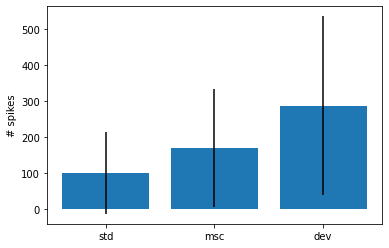

In [144]:
plt.bar(['std', 'msc', 'dev'], [mean_std, mean_msc, mean_dev], yerr=[stddev_std, stddev_msc, stddev_dev])
plt.ylabel('# spikes');

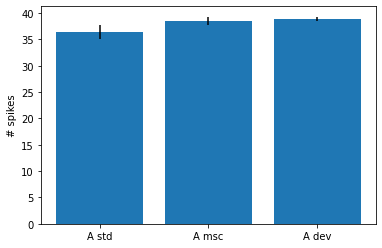

In [145]:
plt.bar(['A std', 'A msc', 'A dev'], [Astd['mean_A'], MSC['mean_A'], Bstd['mean_A']], yerr=[Astd['std_A'], MSC['std_A'], Bstd['std_A']])
plt.ylabel('# spikes');

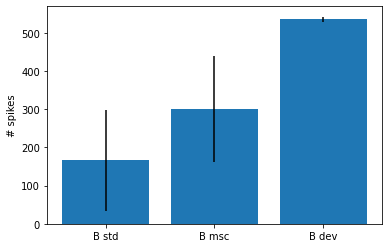

In [146]:
plt.bar(['B std', 'B msc', 'B dev'], [Bstd['mean_B'], MSC['mean_B'], Astd['mean_B']], yerr=[Bstd['std_B'], MSC['std_B'], Astd['std_B']])
plt.ylabel('# spikes');

In [147]:
# device.reinit()
# device.activate()
# Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
# Bstd = {}
# Bstd['Seq'], T = create_oddball(Net, params, B, A)
# Net.run(T)
# Bstd['nspikes'] = get_pulse_spike_counts(Net, params)
# plt.scatter(np.arange(len(Bstd['nspikes'])), Bstd['nspikes'], c=np.where(Bstd['Seq']==A, 'b', 'r'))
# plt.ylim(bottom=0)
# plt.ylabel('# spikes')
# plt.xlabel('Stimulus index');
# Bstd['mean_A'], Bstd['std_A'] = np.mean(Bstd['nspikes'][Bstd['Seq']==A]), np.std(Bstd['nspikes'][Bstd['Seq']==A])
# Bstd['mean_B'], Bstd['std_B'] = np.mean(Bstd['nspikes'][Bstd['Seq']==B]), np.std(Bstd['nspikes'][Bstd['Seq']==B])
# plt.bar(['A', 'B'], [Bstd['mean_A'], Bstd['mean_B']], yerr=[Bstd['std_A'], Bstd['std_B']])
# plt.ylabel('# spikes');